<a href="https://colab.research.google.com/github/jskaza/deep-learning-projects/blob/main/political_slant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install asyncpraw
# !pip install transformers
import asyncpraw
from bs4 import BeautifulSoup
import pandas as pd
from fastai.text.all import *
import requests
import os
import json

In [ ]:
reddit = asyncpraw.Reddit(
    client_id=os.environ.get("CLIENT_ID"),
    client_secret=os.environ.get("CLIENT_SECRET"),
    user_agent=os.environ.get("USER_AGENT")
)

In [ ]:
async def fetch_comments(subreddit: str, label: str, limit = 1000) -> pd.DataFrame:
  comments = []
  subreddit = await reddit.subreddit(subreddit)
  async for comment in subreddit.comments(limit=limit):
    if type(comment) == asyncpraw.models.reddit.comment.Comment and comment.author != "AutoModerator":
        comments.append(BeautifulSoup(comment.body_html).get_text())
  return pd.DataFrame({
      "party": label,
      "text": comments
  })


In [ ]:
dem = await fetch_comments("democrats", "dem")
rep = await fetch_comments("republican", "rep")
df_reddit = pd.concat([dem, rep])
df_reddit.describe()

,party,text
count,1447,1447
unique,2,1446
top,dem,No\n
freq,800,2


In [ ]:
dls = TextDataLoaders.from_df(df_reddit, label_col=0, text_col=1)
dls.show_batch(max_n = 3)

,text,category
0,"xxbos xxmaj on xxmaj xxunk , a federal judge in xxmaj washington , xxup dc sentenced a veteran xxup gop operative to 18 months in prison for xxunk $ 25 , xxrep 3 0 from a xxmaj russian businessman to xxmaj donald xxmaj trump ’s 2016 campaign . \n xxmaj xxunk xxmaj benton , a xxunk xxunk to both xxmaj ron and xxmaj xxunk xxmaj paul , was xxunk in xxmaj xxunk on six xxunk charges . xxmaj the court found that he and another xxup gop operative xxunk $ 100 , xxrep 3 0 from xxmaj xxunk xxmaj vasilenko , a xxmaj xxunk . xxmaj xxunk - based xxunk who wanted xxunk with xxmaj trump to xxunk on his social media accounts . xxmaj benton kept most of the money for himself but xxunk $ 25 , xxrep 3 0 to the xxmaj republican xxmaj national xxmaj committee as",dem
1,xxbos xxmaj simple answer is he ’s only going to govern the things that will make him look good to the base or do nothing . \n xxmaj he let thousands of xxunk deaths happen because of his political agenda during xxup covid . xxmaj he never allowed the real xxup covid numbers to be public . xxmaj and now is trying to xxunk the xxunk . \n xxmaj he ’s gone after xxmaj xxunk cause he was butt hurt about their xxunk xxunk “ do n’t say gay ” and will probably xxunk xxunk of xxmaj florida as a result . \n xxmaj he has done little to nothing for xxunk relief for the people still suffering in his state . \n xxmaj he has done little to nothing over xxunk xxunk of home insurance and xxunk . xxmaj my personal insurance bill has gone up more than $,dem
2,"xxbos i did n't judge any intentions , i just replied to the comment you made . \n xxmaj these stats are great , but it 's really not the smoking gun you think it is . \n xxmaj sadly , this is similar xxunk xxunk use to explain why autism diagnosis is going up . \n "" more xxunk , more autism ! xxmaj xxunk must be xxunk autism right ? "" \n xxmaj wrong . \n xxmaj the reason there is "" more "" autism is because there is more xxunk of autism . xxmaj there are more xxunk xxunk being done . xxmaj medical xxunk are paying closer attention for xxunk of autism in children . \n https : / / xxrep 3 w xxunk / health / health - news / autism - rates - xxunk - more - xxunk - xxunk - more - xxunk",dem


In [ ]:
# drop_mult , a hyper-parameter ,used for regularization, sets the amount of dropout. 
# If the model is over-fitting increase it, if under-fitting, you can decrease the number.
learn = text_classifier_learner(dls, AWD_LSTM, metrics=accuracy)
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,time
0,0.754708,0.681200,0.539792,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.674619,0.663867,0.577855,00:03
1,0.642445,0.648966,0.626298,00:03
2,0.629623,0.648059,0.619377,00:03
3,0.616817,0.648618,0.615917,00:03
4,0.607061,0.636392,0.667820,00:03
5,0.585382,0.631511,0.674740,00:03
6,0.554211,0.651607,0.657439,00:03
7,0.529682,0.649611,0.640138,00:03
8,0.497424,0.638280,0.664360,00:03
9,0.468245,0.636533,0.674740,00:04


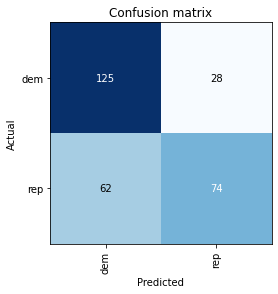

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# def fetch_party_site(domain_url: str, party: str) -> pd.DataFrame:
#   text = []
#   response = requests.get(domain_url)
#   soup = BeautifulSoup(response.content, 'html.parser')
#   links = [link.get('href') for link in soup.find_all('a')]
#   for link in links:
#     try:
#       if link.startswith(domain_url):
#           response = requests.get(link)
#           soup = BeautifulSoup(response.content, 'html.parser')
#           text.append(soup.get_text())
#     except:
#       print(f"unable to retrieve {link}")

#   return pd.DataFrame({
#       "party": party,
#       "text": text
#   })

In [ ]:
# dem = fetch_party_site("https://massdems.org/", "democrats")
# rep = fetch_party_site("https://www.florida.gop/", "republican")
# df_party = pd.concat([dem, rep])
# df_party.describe()

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# text = "example text"

# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")


# inputs = tokenizer(text, return_tensors="pt")
# outputs = model(**inputs)
# [0] -> left 
# [1] -> center
# [2] -> right


In [ ]:
# torch.nn.functional.softmax(outputs[0])


<ipython-input-37-bec1db960cbc>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(outputs[0])


tensor([[0.4257, 0.2210, 0.3533]], grad_fn=<SoftmaxBackward0>)